In [14]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)
sns.set(style="darkgrid")
style.use('seaborn-bright')

# TODO
# One hot encoding
# hash encoding
# preprocessing

## Exploring and cleaning the data

In [12]:
df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)
df.info()

File `file_name.py` exists. Overwrite (y/[N])?  y
'_oh[0]' was not found in history, as a file, url, nor in the user namespace.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null datetime64[ns]
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    275665 non-null object
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null datetime64[ns]
accountcode                   

In [10]:
# Inspect the amount of missing data we have and filter it out
# All of the missing data is categorical, with by far the most values missing in the column 
# cardverificationcodesupplied, a boolean value column

print(f'Total missing values: {df.isnull().values.sum()}\n')
print(f'Missing value distribution: \n{df.isnull().sum()}')

# Drop the missing values
df_unclean = df.copy()
df = df.dropna()

Total missing values: 15832

Missing value distribution: 
txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64


In [198]:
# Printing more info on the columns: possible values that are seen in the dataset
for col in df.columns:
    print(f'Column: {col}')
    print(df[col].unique())
    print(f'length: {len(df[col])}')

Column: txid
[     1      2      3 ... 482732 482733 482734]
length: 274567
Column: bookingdate
['2015-11-09T14:26:51.000000000' '2015-11-09T14:27:38.000000000'
 '2015-11-23T16:34:16.000000000' ... '2015-10-31T22:03:39.000000000'
 '2015-11-02T20:16:57.000000000' '2015-11-03T18:57:01.000000000']
length: 274567
Column: issuercountrycode
['MX' 'US' 'BR' 'CA' 'ES' 'CH' 'SA' 'TH' 'SG' 'NL' 'GB' 'IN' 'TW' 'MY'
 'DO' 'CO' 'CL' 'UA' 'AU' 'BE' 'TZ' 'PH' 'IT' 'DE' 'HU' 'KZ' 'GR' 'KE'
 'IL' 'VN' 'NO' 'AR' 'CN' 'HN' 'EG' 'AE' 'BB' 'FR' 'ID' 'BA' 'FI' 'PE'
 'RU' 'HK' 'KR' 'NZ' 'TR' 'IE' 'PK' 'SE' 'RO' 'EC' 'UY' 'BS' 'BH' 'PA'
 'BO' 'DK' 'QA' 'BZ' 'MT' 'LB' 'VE' 'JP' 'SV' 'LK' 'ZA' 'CK' 'LA' 'KH'
 'AT' 'MO' 'FJ' 'RS' 'LU' 'SB' 'JO' 'ZM' 'AO' 'PL' 'NG' 'LT' 'IQ' 'BG'
 'PT' 'GE' 'GI' 'LV' 'KW' 'BM' 'OM' 'CY' 'SK' 'ZZ' 'AL' 'GH' 'MU' 'MD'
 'SL' 'CR' 'BN' 'LY' 'ZW' 'SI' 'IS' 'BY' 'TJ' 'BW' 'MK' 'HR' 'VG' 'BD'
 'EE' 'CW' 'AZ' 'AM' 'AI' 'MN' 'TM' 'ME' 'AD' 'GT' 'PR' 'DZ' 'TT' 'CZ'
 'KY' 'CG' 'CM' 'BJ' 'BF

### Preprocessing 
We pre-process the dataset to prepare for visualization

- 1 remove Refused transactions
- 2 add amount_converted column with GBP amount
- 3 Add boolean is_fraud column

In [218]:
df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)
# First remove the refused transactions
df = df[df['simple_journal'] != 'Refused']

# Fill cardverificationcodesupplied NaN values with False
df.cardverificationcodesupplied.fillna(value=False, inplace=True)

def convert_currency(row):
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency])

def fix_countrycodes(row):
    if pd.isnull(row.issuercountrycode):
        row.issuercountrycode = row.shoppercountrycode
    elif pd.isnull(row.shoppercountrycode):
        row.shoppercountrycode = row.issuercountrycode
    return row
    
def changerows(row):
    if row.txid % 50000 == 0:
        print(row)
        
    # Now we add a column to all the data containing the transacted amount in GBP. 
    row['amount_convert'] = convert_currency(row)
    
    # if countrycodes are NaN use the code of the issuer/shoppercountry 
    row = fix_countrycodes(row)
    
    # map cvc response code to 0,1,2,3
    map_cvc = {0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3}
    
    row['cvcresponsecode'] = map_cvc[row['cvcresponsecode']]
    # Add is_fraud column for ease of use
    row['is_fraud'] = row['simple_journal'] == 'Chargeback'
    return row

df = df.apply(changerows, axis=1)
# df['amount_convert'] = df.apply(lambda x: changerows(x), axis=1)
# df_no_refused = df_no_refused.apply(fix_countrycodes, axis=1)

df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_convert,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2629,True
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1822,True
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6081,True
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4459,True
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3647,True


In [200]:
# Grouping on simple_journal and check mean values to check for differences

df.groupby(df['is_fraud']).mean()

# Fraudulent transactions have generally lower cvc response codes

,txid,bin,amount,cvcresponsecode,amount_convert,is_fraud
is_fraud,,,,,,
False,280627.168763,485001.954061,19589.096892,0.805821,6774.487939,False
True,73571.394203,498004.162319,105137.652174,0.121739,13068.417391,True


txvariantcode
electron              18
mccredit           47377
mcdebit            12528
visa                1266
visabusiness         295
visaclassic        10813
visacorporate        332
visadebit         137752
visagold            4471
visaplatinum        8322
visapurchasing        38
visasignature        298
Name: txid, dtype: int64


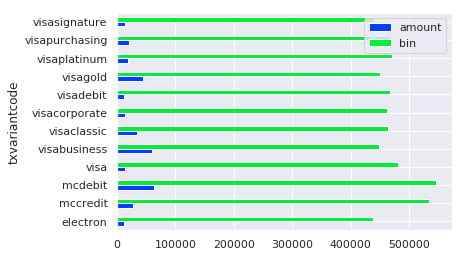

In [187]:
# Count the number of transactions done using the different txvariantcodes
txgroup = df.groupby(by=['txvariantcode'])
tx_avg = txgroup.mean()
tx_count = txgroup.count()

print(tx_count['txid'])

tx_series = tx_count.iloc[:,0]

features_of_interest = pd.DataFrame({'amount': tx_avg['amount'], 'bin': tx_avg['bin']})

features_of_interest.plot(kind='barh')

/usr/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


mean: 
#is_fraud
False     19589.096892
True     105137.652174
Name: amount, dtype: float64

std: 
#is_fraud
False     42373.252464
True     124188.477258
Name: amount, dtype: float64

max amount: 
#is_fraud
False    1955765.0
True      769500.0
Name: amount, dtype: float64



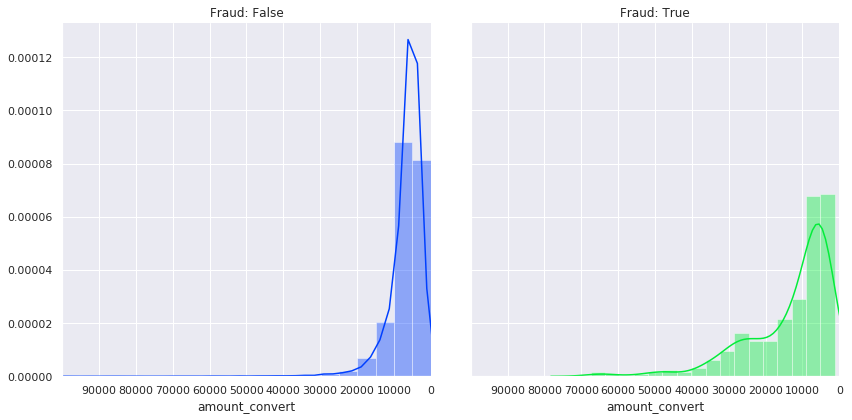

In [186]:
## Visualize fraud vs amounts
g = sns.FacetGrid(df, col="is_fraud", size=6,hue='is_fraud', sharex=True, xlim=100000)
g.map(sns.distplot,"amount_convert", kde=True)
g.set(xticks=range(0,100000, 10000))
g.set_titles('Fraud: {col_name}')

print(f"mean: \n#{df.groupby(by=['is_fraud'])['amount'].mean()}\n")
print(f"std: \n#{df.groupby(by=['is_fraud'])['amount'].std()}\n")
print(f"max amount: \n#{df.groupby(by=['is_fraud'])['amount'].max()}\n")

Form the plots above we can see that the transacted amount for fraud transactions is higher on average than the non fraud ones, and also contain more outliers for the higher amounts.

Looking at the numerical values of the mean and deviation the transacted amounts we see confirmation that the mean amount of fraudulent transactions is much higher than non-fraudulent ones, mainly caused by large outliers.


/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


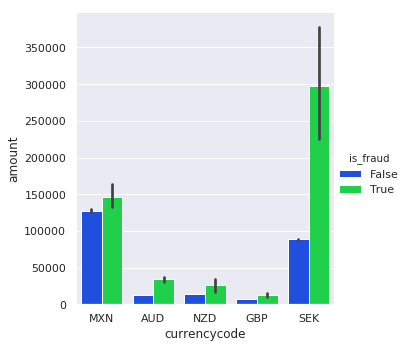

In [188]:

sns.factorplot(data=df, kind='bar', x="currencycode", y="amount", hue="is_fraud")


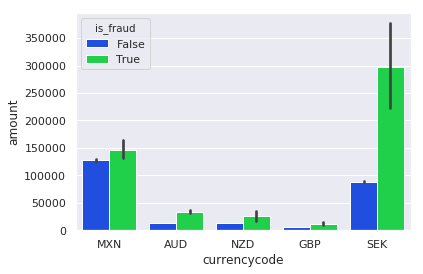

In [189]:
# Bar plot of fraud vs legit transations per currencycode
sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")

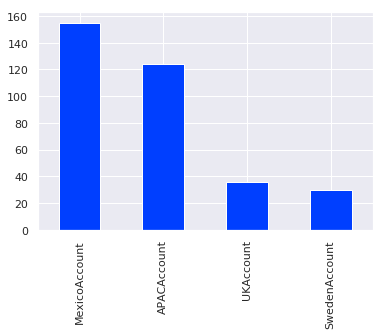

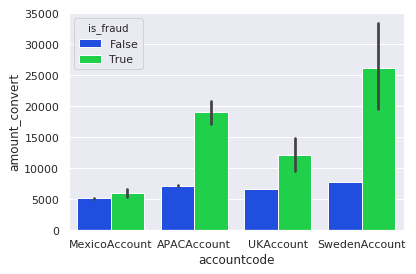

In [190]:
# Amount of fraudulent tranactions per account code
# MexicoAccount has by far the most fraudulent transations, but the amounts are much lower per fraudulent transaction.
# SwedenAccount has the lowest number of fraudulent txs, but the amount of money involved is the highest
fraudulent = df[df["is_fraud"] == 1]
plt.figure()
fraudulent['accountcode'].value_counts().plot(kind='bar')
plt.figure()
sns.barplot(data=df, x="accountcode", y="amount_convert", hue="is_fraud")

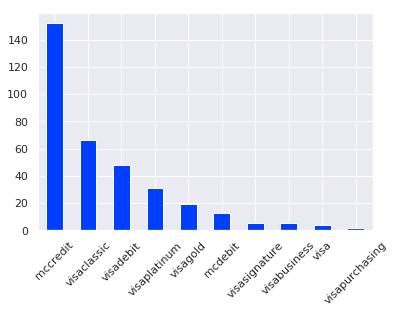

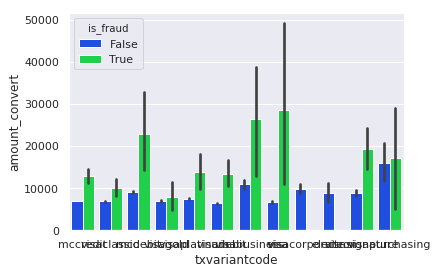

In [191]:
# same visualisation as above but with txvariantcode.
# Mccredit has the highest num of fraud tx but not the highest amount, although there are some with way less
plt.figure()
fraudulent['txvariantcode'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.figure()
sns.barplot(data=df, x="txvariantcode", y="amount_convert", hue="is_fraud")

<Figure size 432x288 with 0 Axes>

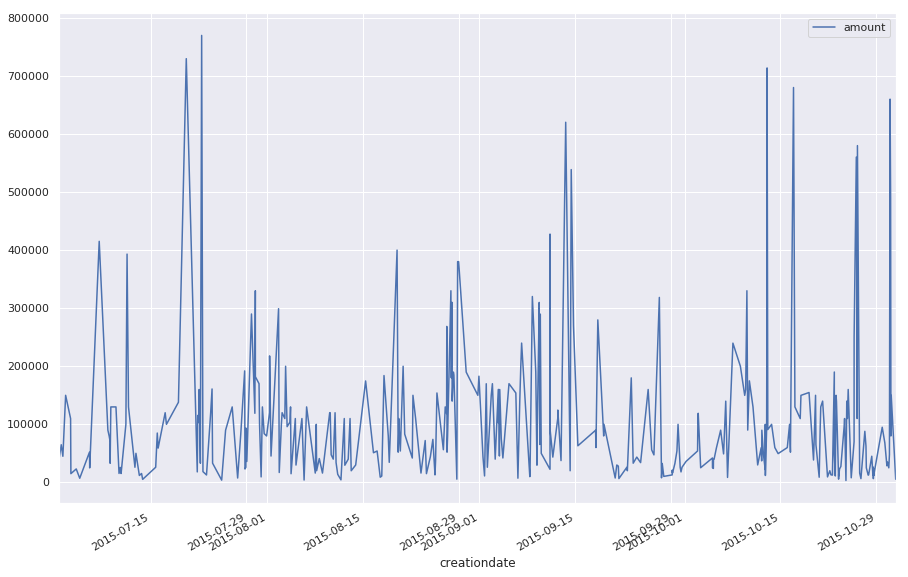

In [18]:
# Amount of fraud over time shows a very small decline in the amount of fraud committed over time.
fraudulent = df[df["is_fraud"] == 1]
len(fraudulent)

# attempt 1
# sns.lineplot(x="bookingdate", y="amount", data=fraudulent.sort_index(by='bookingdate'))

#attempt 2
# fraudulent.set_index("bookingdate").groupby(pd.Grouper(freq='M')).head()
# plt = sns.lineplot(x="creationdate", y="amount", data=gr)
# plt.xticks(rotation=70)

#attempt 3
plt.figure();
fraudulent.set_index("creationdate").plot(figsize=(15,10), y='amount')

In [19]:
# amount of fraud per month of the year, no idea how to make a bar plot of this..
fraudulent = df[df["is_fraud"] == 1]
monthly = fraudulent['amount'].groupby(df['bookingdate'].dt.month).mean()

monthly = df.groupby(df['bookingdate'].dt.month).mean()


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


spent_in_issue_country  is_fraud
False                   False         6877
                        True            14
True                    False       229814
                        True           331
Name: is_fraud, dtype: int64


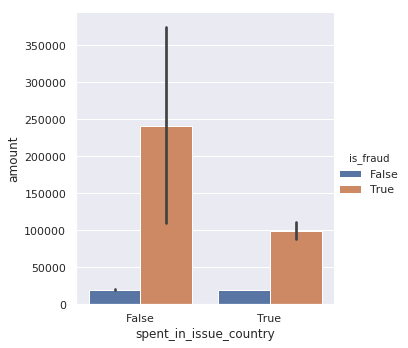

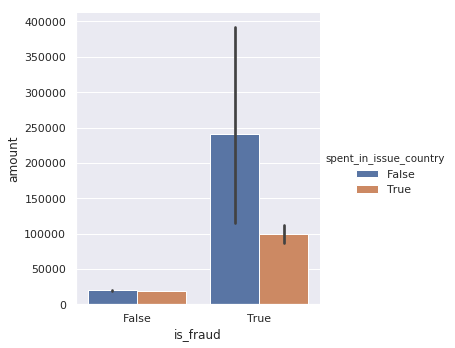

In [20]:
# Attempting to explore is theres a higher chance of fraud when issuercountrycode != shoppercountrycode

is_equal = df[df['issuercountrycode'] == df['shoppercountrycode']]
not_equal = df[df['issuercountrycode'] != df['shoppercountrycode']]

spent_in_issue_country = df['issuercountrycode'] == df['shoppercountrycode']
df['spent_in_issue_country'] = spent_in_issue_country
# sns.barplot(data=is_equal, x="currencycode", y="amount", hue="is_fraud")
# sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")

# is_equal['is_fraud']
# fig1, ax1 = plt.subplots()
# ax1.pie(is_equal['is_fraud'], labels=['is fraud', 'is not fraud'], autopct='%1.1f%%', shadow=True)
# ax1.axis('equal')
# plt.show()
# df.plot(kind='pie', y='amount')

sns.factorplot(data=df, kind='bar', x="spent_in_issue_country", y="amount", hue="is_fraud")
sns.factorplot(data=df, kind='bar', x="is_fraud", y="amount", hue="spent_in_issue_country")

group = df.groupby(["spent_in_issue_country", "is_fraud"])["is_fraud"].count()
# group[0].plot.bar(title="spent_in_issue_country=False")
# group[1].plot.bar(title="spent_in_issue_country=True")

# group[0].plot.pie(subplots=True)
print(group)

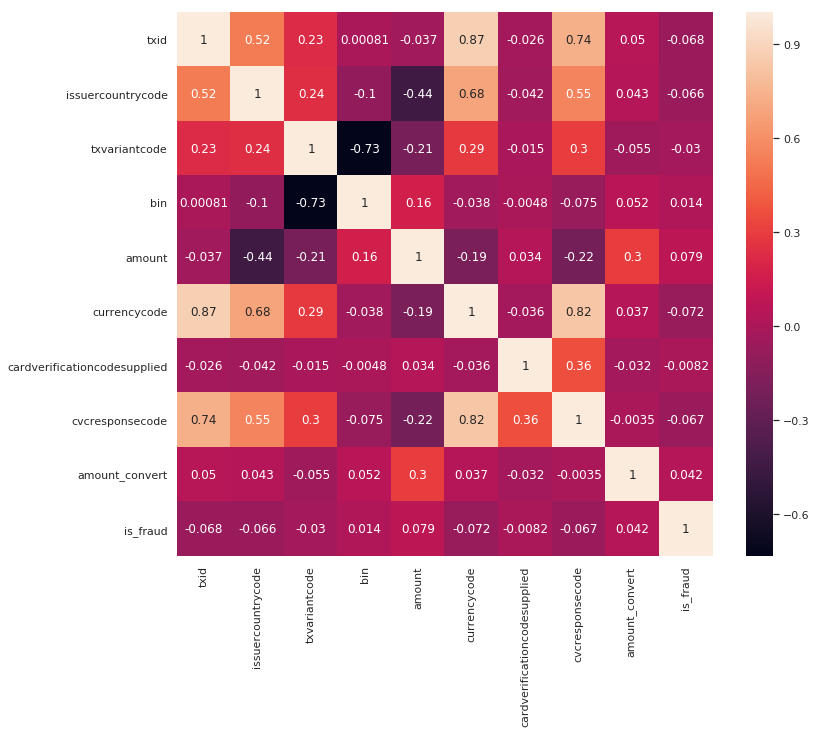

In [219]:
# Heatmap, only numerical data is taken into account, 
# may need to encode some data to add exra columns <- may cause wrong correlations?
# is_fraud appears to have extremely low correlation with all other columns, 
# especially the column of interest 'is_fraud'

def create_list_mapping(somelist):
    # takes a list eg ["A", "B"] and maps it to a dict eq {"A": 0, "B": 1}
    return {x:somelist.tolist().index(x) for x in somelist}

issuercountrycode_map = create_list_mapping(df['issuercountrycode'].unique())
txvariantcode_map = create_list_mapping(df['txvariantcode'].unique())
currencycode_map = create_list_mapping(df['currencycode'].unique())

df_remapped = df.replace(issuercountrycode_map)
df_remapped = df_remapped.replace(txvariantcode_map)
df_remapped = df_remapped.replace(currencycode_map)

plt.figure(figsize=(12,10))
sns.heatmap(df_remapped.corr(), annot=True)

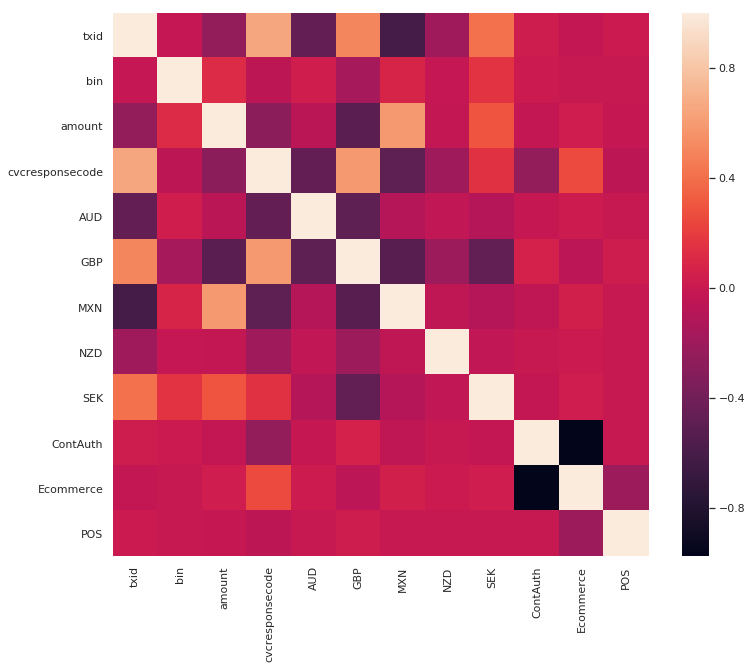

In [16]:
## Heatmap with onehotencoding
df_onehot = df.copy()
df_onehot.head()
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df['currencycode'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
df_onehot = pd.concat([df_onehot, lb_results_df], axis=1)

lb_results = lb.fit_transform(df['shopperinteraction'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
df_onehot = pd.concat([df_onehot, lb_results_df], axis=1)

plt.figure(figsize=(12,10))
sns.heatmap(df_onehot.corr(), annot=True)

In [206]:
def cat_to_oneh(dataframe, column):
    df1 = dataframe.copy()
    df1 = df[column]
    df1 = df1.apply(lambda x: str(hash(x))[1:10])
    df1 = pd.DataFrame(df1.str.split('',).tolist())
    df1 = df1.drop([0,10], axis=1)
    return pd.get_dummies(df1)

In [208]:
dftest = cat_to_oneh(df, 'txvariantcode')

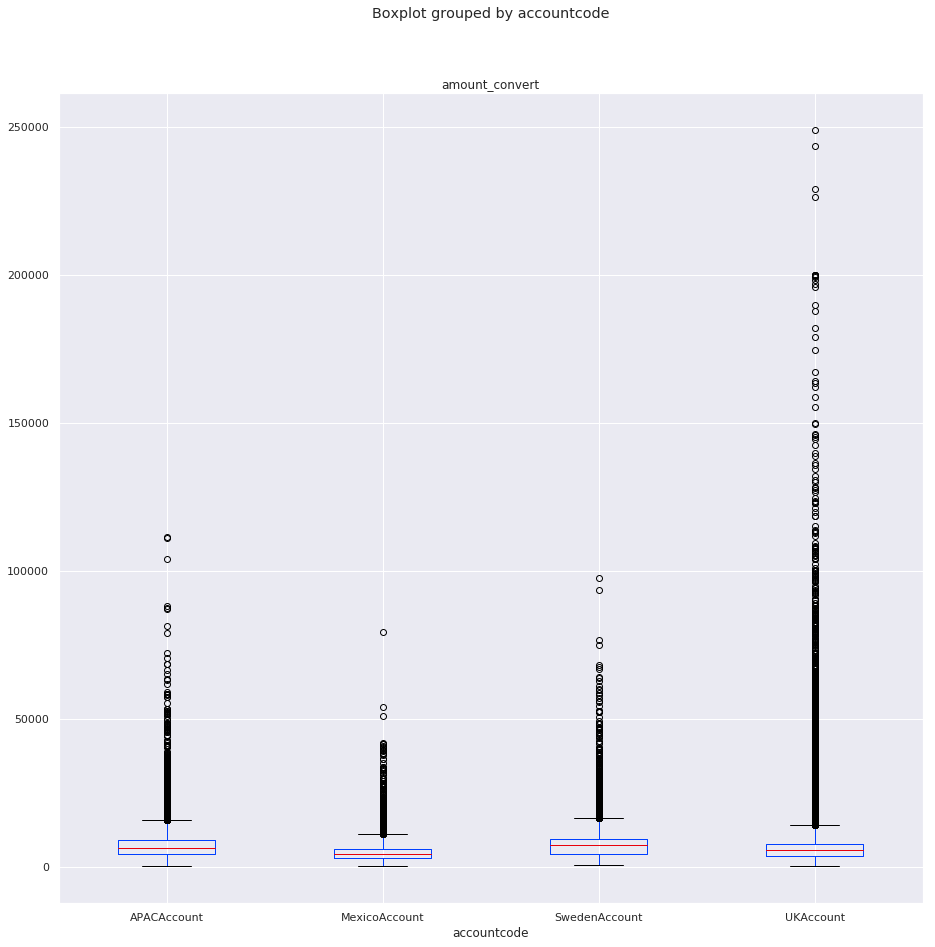

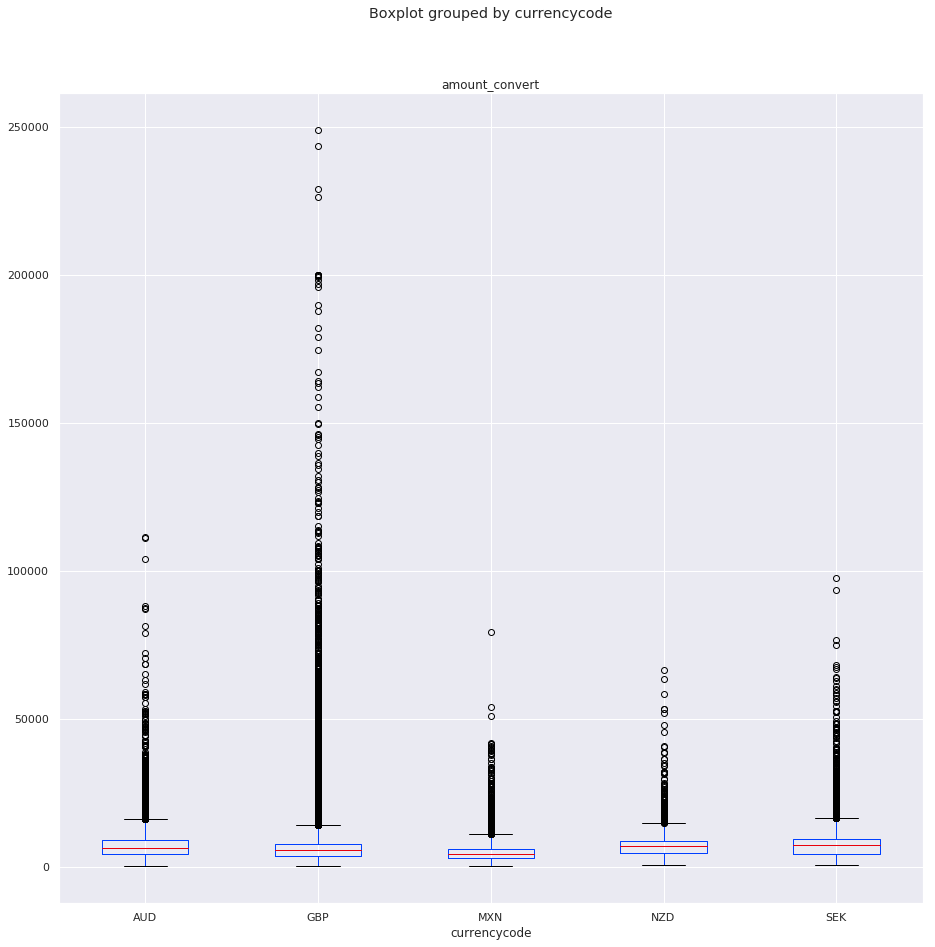

In [193]:
df.boxplot('amount_convert', 'accountcode', figsize=(15,15))
df.boxplot('amount_convert', 'currencycode', figsize=(15,15))

In [6]:
# No card verification code supplied has no cases of fraud,
df_unclean['hascardverification'] = df_unclean['cardverificationcodesupplied'].apply(lambda x: isinstance(x, int))
sns.factorplot(data=df_unclean, kind='bar', x="hascardverification", y="amount", hue='is_fraud')

df_unclean.groupby([df_unclean['hascardverification'], df_unclean['is_fraud']]).count()

'_oh[7]' was not found in history, as a file, url, nor in the user namespace.


NameError: name 'df_unclean' is not defined

## Imbalance Task
Process the data such that you can apply SMOTE to it. SMOTE is included in most analysis platforms, if not you can write the scripts for it yourself. Analyze the performance of at least three classifiers on the SMOTEd and UNSMOTEd data using ROC analysis. Provide the obtained ROC curves and explain which method performs best. Is using SMOTE a good idea? Why (not)

Classifiers:
- Random Forest
- Logistic Regression 
- Support Vector Machine

In [5]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

data = pd.read_csv('data.csv')  # load data set
X = data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X) # make predictions

ModuleNotFoundError: No module named 'utilities'